In [109]:
import numpy as np
import pandas as pd
import pickle
from skimage import io
from skimage.io import imread, imsave
from skimage import img_as_ubyte
from matplotlib import pyplot as plt
from collections import Counter

from platform import python_version

%matplotlib inline

np.__version__, python_version()

('1.18.5', '3.8.3')

### Allowed imports

In [2]:
import numpy as np
from skimage.feature import ORB, match_descriptors
from skimage.color import rgb2gray
from skimage.transform import ProjectiveTransform
from skimage.transform import warp
from skimage.filters import gaussian
from numpy.linalg import inv
DEFAULT_TRANSFORM = ProjectiveTransform

### Images

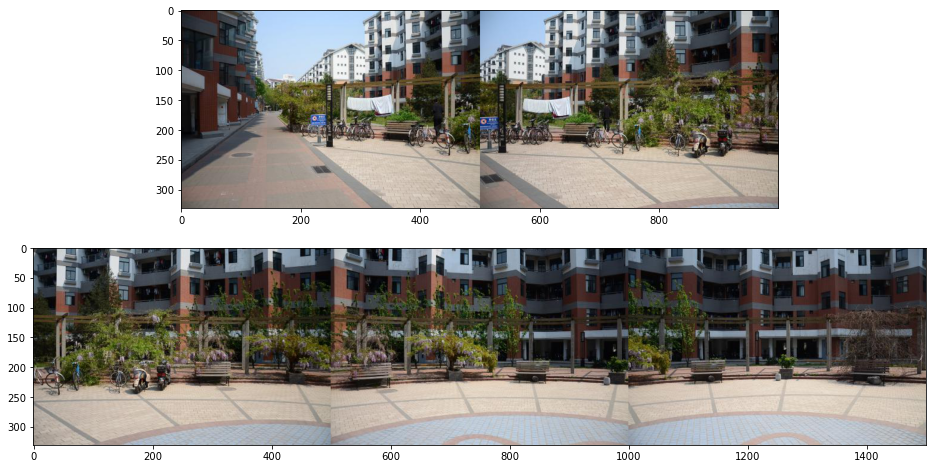

In [100]:
imgs = [imread(f'imgs/01/kk1_medium0{i}.jpg') for i in range(2,7)]

plt.figure(figsize=(16,8))

plt.subplot(2, 1, 1)
plt.imshow(np.hstack(imgs[:2]))
plt.subplot(2, 1, 2)
plt.imshow(np.hstack(imgs[2:]))

### 1. Keypoints

In [101]:
def find_orb(img, n_keypoints):
    """Find keypoints and their descriptors in image.

    img ((W, H, 3)  np.ndarray) : 3-channel image
    n_keypoints (int) : number of keypoints to find

    Returns:
        (N, 2)  np.ndarray : keypoints
        (N, 256)  np.ndarray, type=np.bool  : descriptors
    """

    # your code here
    image = rgb2gray(img)
    descriptor_extractor = ORB(n_keypoints=n_keypoints)
    descriptor_extractor.detect_and_extract(image)
    keypoints = descriptor_extractor.keypoints
    descriptors = descriptor_extractor.descriptors
    return keypoints, descriptors

(331, 500, 3) (200, 2) (200, 256)


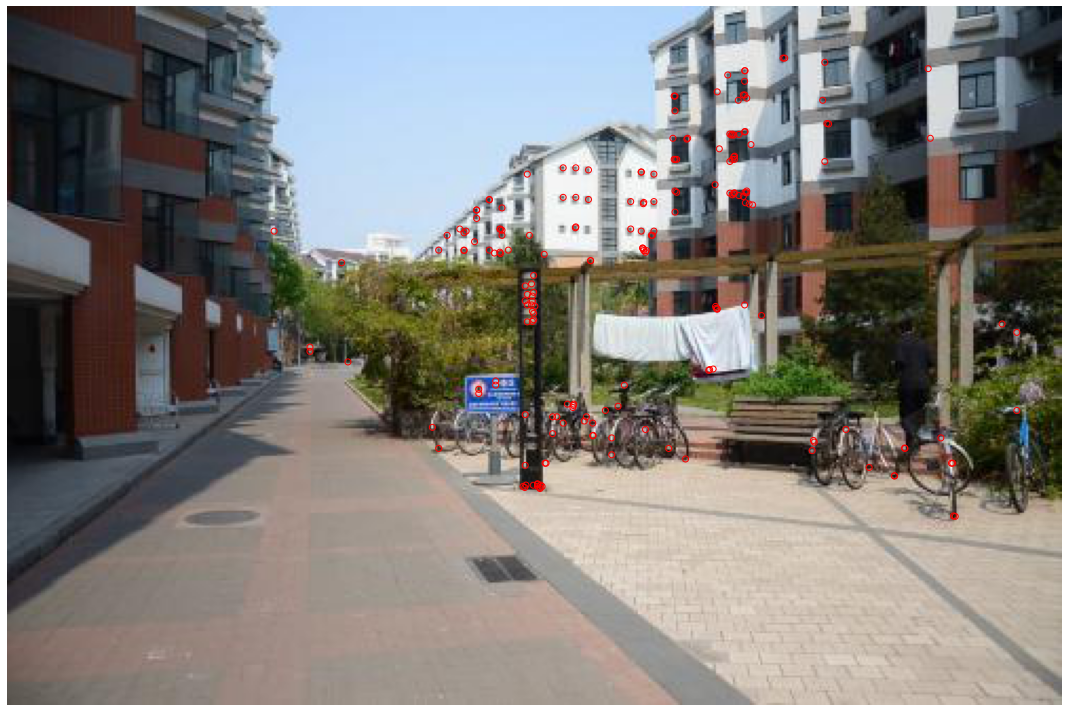

In [102]:
import plots

keypoints, descriptors = find_orb(imgs[0], 200)
print(im.shape, keypoints.shape, descriptors.shape)
plots.plot_keypoints('', imgs[0], keypoints)

### 2. Homography

In [103]:
def center_and_normalize_points(points):
    """Center the image points, such that the new coordinate system has its
    origin at the centroid of the image points.

    Normalize the image points, such that the mean distance from the points
    to the origin of the coordinate system is sqrt(2).

    points ((N, 2) np.ndarray) : the coordinates of the image points

    Returns:
        (3, 3) np.ndarray : the transformation matrix to obtain the new points
        (N, 2) np.ndarray : the transformed image points
    """
    pointsh = np.row_stack([points.T, np.ones((points.shape[0]), )])
    matrix = np.zeros((3, 3))

    # your code here
    C_x, C_y = points.mean(axis=0)
    points_centered = points - np.array([C_x, C_y])
    N = np.sqrt(2) / np.sqrt((points_centered**2).sum(axis=1)).mean()
    matrix = np.array([[N, 0, - N * C_x],
                       [0, N, - N * C_y],
                       [0, 0, 1]])
    transformed_points = (matrix @ pointsh).T[:,:-1]
    
    return matrix, transformed_points

In [104]:
matrix, transformed_points = center_and_normalize_points(keypoints)
print(transformed_points.shape)
matrix

(200, 2)


array([[ 0.01758879,  0.        , -2.24889923],
       [ 0.        ,  0.01758879, -5.25844641],
       [ 0.        ,  0.        ,  1.        ]])

In [105]:
def find_homography(src_keypoints, dest_keypoints):
    """Estimate homography matrix from two sets of N (4+) corresponding points.

    src_keypoints ((N, 2) np.ndarray) : source coordinates
    dest_keypoints ((N, 2) np.ndarray) : destination coordinates

    Returns:
        ((3, 3) np.ndarray) : homography matrix
    """
    src_matrix, src = center_and_normalize_points(src_keypoints)
    dest_matrix, dest = center_and_normalize_points(dest_keypoints)

    # your code here
    N = src_keypoints.shape[0]
    A = []
    for i in range(N):
        (x_1, y_1), (x_2, y_2) = src[i], dest[i]
        a_x = np.array([-x_1, -y_1, -1, 0, 0, 0, x_2*x_1, x_2*y_1, x_2])
        a_y = np.array([0, 0, 0, -x_1, -y_1, -1, y_2*x_1, y_2*y_1, y_2])
        A.append([a_x, a_y])
        
    _, _, VT = np.linalg.svd(np.vstack(A))
    H = VT[-1].reshape(3, 3)
    return inv(dest_matrix) @ H @ src_matrix

In [106]:
src_keypoints = np.array([[166, 220],
                        [213, 151],
                        [178, 392],
                        [158.4, 199.2],
                        [213, 185],
                        [204, 253]])

dest_keypoints = np.array([[165, 138],
                        [214, 66],
                        [178, 309],
                        [158.4, 116.4],
                        [214, 102],
                        [205, 171]])

H = find_homography(src_keypoints, dest_keypoints)
assert np.mean(np.linalg.norm(dest_keypoints - ProjectiveTransform(H)(src_keypoints), axis=1)) < 1
print("OK")

OK


### 3. RANSAC

In [139]:
def ransac_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, max_trials=100, residual_threshold=2, return_matches=False):
    """Match keypoints of 2 images and find ProjectiveTransform using RANSAC algorithm.

    src_keypoints ((N, 2) np.ndarray) : source coordinates
    src_descriptors ((N, 256) np.ndarray) : source descriptors
    dest_keypoints ((N, 2) np.ndarray) : destination coordinates
    dest_descriptors ((N, 256) np.ndarray) : destination descriptors
    max_trials (int) : maximum number of iterations for random sample selection.
    residual_threshold (float) : maximum distance for a data point to be classified as an inlier.
    return_matches (bool) : if True function returns matches

    Returns:
        skimage.transform.ProjectiveTransform : transform of source image to destination image
        (Optional)(N, 2) np.ndarray : inliers' indexes of source and destination images
    """

    # your code here
    approx_matches = match_descriptors(src_descriptors, dest_descriptors)
    N = approx_matches.shape[0]
    src_matches = src_keypoints[approx_matches[:,0]]
    dest_matches = dest_keypoints[approx_matches[:,1]]
    best_H = np.zeros((3,3))
    best_n_inliners = 0
    
    for _ in range(max_trials):
        indices = np.random.choice(range(N), 4)
        src_sample, dest_sample = src_matches[indices], dest_matches[indices]
        H = find_homography(src_sample, dest_sample)
        n_inliners = sum(np.linalg.norm(dest_matches - ProjectiveTransform(H)(src_matches), 
                                        axis=1) < residual_threshold)
        if n_inliners > best_n_inliners:
            best_H = H
            best_n_inliners = n_inliners
            
    inliners = np.linalg.norm(dest_matches - ProjectiveTransform(best_H)(src_matches), axis=1) < residual_threshold
    H = find_homography(src_matches[inliners], dest_matches[inliners])
    
    if return_matches:
        return ProjectiveTransform(H), approx_matches[inliners]
    else:
        return ProjectiveTransform(H)

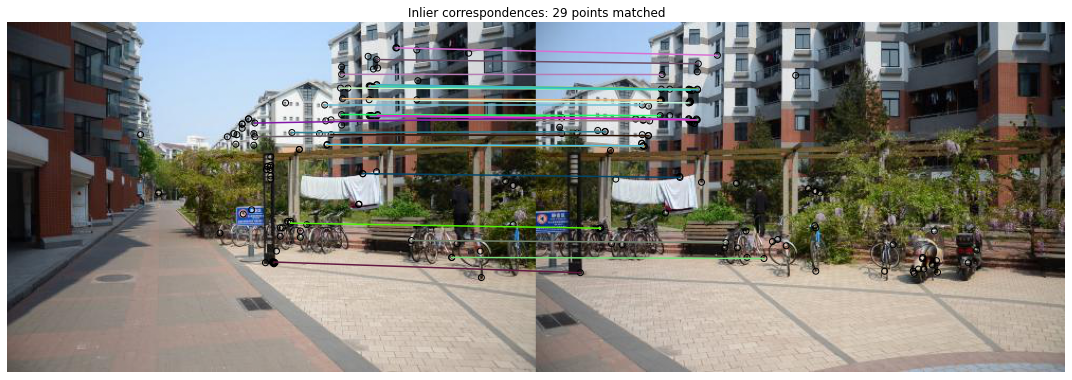

In [125]:
src, dest = imgs[0], imgs[1]
src_keypoints, src_descriptors = find_orb(src, 100)
dest_keypoints, dest_descriptors = find_orb(dest, 100)

robust_transform, matches = ransac_transform(src_keypoints, src_descriptors, dest_keypoints, 
                                             dest_descriptors, return_matches=True)

plots.plot_inliers('', src, dest, src_keypoints, dest_keypoints, matches)

### 4. Frames to central plane

In [140]:
def find_simple_center_warps(forward_transforms):
    """Find transformations that transform each image to plane of the central image.

    forward_transforms (Tuple[N]) : - pairwise transformations

    Returns:
        Tuple[N + 1] : transformations to the plane of central image
    """
    image_count = len(forward_transforms) + 1
    center_index = (image_count - 1) // 2

    result = [None] * image_count
    result[center_index] = DEFAULT_TRANSFORM()

    # your code here
    for i in range(center_index-1, -1, -1):
        result[i] = forward_transforms[i] + result[i+1]
    for i in range(center_index, image_count-1):
        H = inv(forward_transforms[i].params)
        result[i+1] = ProjectiveTransform(H) + result[i]
    return tuple(result)


def get_corners(image_collection, center_warps):
    """Get corners' coordinates after transformation."""
    for img, transform in zip(image_collection, center_warps):
        height, width, _ = img.shape
        corners = np.array([[0, 0],
                            [height, 0],
                            [height, width],
                            [0, width]])

        yield transform(corners)[:, ::-1]


def get_min_max_coords(corners):
    """Get minimum and maximum coordinates of corners."""
    corners = np.concatenate(corners)
    return corners.min(axis=0), corners.max(axis=0)


def get_final_center_warps(image_collection, simple_center_warps):
    """Find final transformations.

        image_collection (Tuple[N]) : list of all images
        simple_center_warps (Tuple[N])  : transformations unadjusted for shift

        Returns:
            Tuple[N] : final transformations
        """
    # your code here
    img_corners = tuple(get_corners(image_collection, simple_center_warps))
    min_corner, max_corner = get_min_max_coords(img_corners)
    shape = (max_corner - min_corner)[::-1].astype(int)
    H = np.array([[1, 0, - min_corner[1]],
                  [0, 1, - min_corner[0]],
                  [0, 0, 1]])
    final_transformations = []
    for warp in simple_center_warps:
        final_transformations.append(warp + ProjectiveTransform(H))
    return tuple(final_transformations), shape

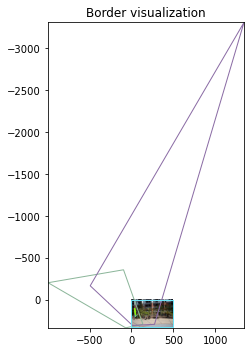

In [142]:
keypoints, descriptors = zip(*(find_orb(img, 200) for img in imgs))
forward_transforms = tuple(ransac_transform(src_kp, src_desc, dest_kp, dest_desc)
                           for src_kp, src_desc, dest_kp, dest_desc
                           in zip(keypoints[:-1], descriptors[:-1], keypoints[1:], descriptors[1:]))

simple_center_warps = find_simple_center_warps(forward_transforms)
corners = tuple(get_corners(imgs, simple_center_warps))
min_coords, max_coords = get_min_max_coords(corners)
center_img = imgs[(len(imgs) - 1) // 2]
plots.plot_warps('', corners, min_coords=min_coords, max_coords=max_coords, img=center_img)

# final_center_warps, output_shape = get_final_center_warps(imgs, simple_center_warps)
# corners = tuple(get_corners(imgs, final_center_warps))
# plots.plot_warps('', corners=corners, output_shape=output_shape)

### 5. Aligning

In [22]:
def rotate_transform_matrix(transform):
    """Rotate matrix so it can be applied to row:col coordinates."""
    matrix = transform.params[(1, 0, 2), :][:, (1, 0, 2)]
    return type(transform)(matrix)


def warp_image(image, transform, output_shape):
    """Apply transformation to an image and its mask

    image ((W, H, 3)  np.ndarray) : image for transformation
    transform (skimage.transform.ProjectiveTransform): transformation to apply
    output_shape (int, int) : shape of the final pano

    Returns:
        (W, H, 3)  np.ndarray : warped image
        (W, H)  np.ndarray : warped mask
    """
    # your code here
    warped_image = warp(image=image, 
                        inverse_map=rotate_transform_matrix(transform).inverse,
                        output_shape=output_shape)
    warped_mask = warp(image=np.ones(image.shape[:2]), 
                        inverse_map=rotate_transform_matrix(transform).inverse,
                        output_shape=output_shape).astype(bool)
    return warped_image, warped_mask


def merge_pano(image_collection, final_center_warps, output_shape):
    """ Merge the whole panorama

    image_collection (Tuple[N]) : list of all images
    final_center_warps (Tuple[N])  : transformations
    output_shape (int, int) : shape of the final pano

    Returns:
        (output_shape) np.ndarray: final pano
    """
    result = np.zeros(tuple(output_shape) + (3,))
    result_mask = np.zeros(output_shape, dtype=np.bool8)

    # your code here
    for image, mask in zip(image_collection, final_center_warps):
        image_new, mask_new = warp_image(image, mask, output_shape)
        mask_new[result_mask] = False
        result_mask = np.logical_or(result_mask, mask_new)
        result += image_new * np.repeat(mask_new[..., None], repeats=3, axis=2)
    return result

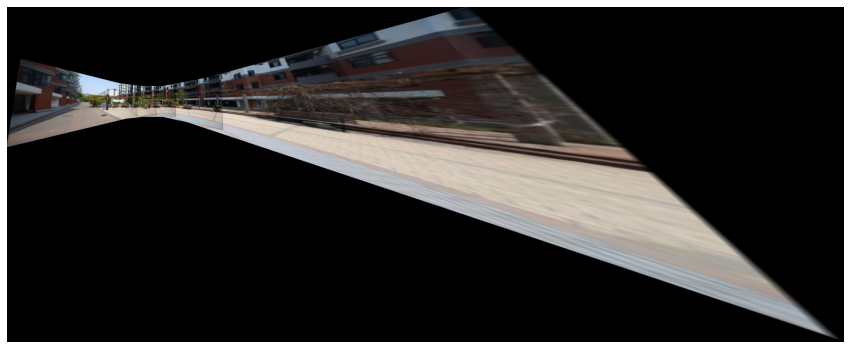

In [23]:
result = merge_pano(pano_image_collection, final_center_warps, output_shape)
try:
    plots.plot_result('', result)
except ValueError:
    pass

### 6. Merging with Gauss and Laplace

In [24]:
def get_gaussian_pyramid(image, n_layers, sigma):
    """Get Gaussian pyramid.

    image ((W, H, 3)  np.ndarray) : original image
    n_layers (int) : number of layers in Gaussian pyramid
    sigma (int) : Gaussian sigma

    Returns:
        tuple(n_layers) Gaussian pyramid

    """
    # your code here
    pyramid = [image]
    for _ in range(n_layers-1):
        image = gaussian(image, sigma)
        pyramid.append(image)
    return tuple(pyramid)


def get_laplacian_pyramid(image, n_layers, sigma):
    """Get Laplacian pyramid

    image ((W, H, 3)  np.ndarray) : original image
    n_layers (int) : number of layers in Laplacian pyramid
    sigma (int) : Gaussian sigma

    Returns:
        tuple(n_layers) Laplacian pyramid
    """
    # your code here
    gaussian_pyramid = get_gaussian_pyramid(image, n_layers, sigma)
    laplacian_pyramid = []
    for i in range(n_layers-1):
        delta = gaussian_pyramid[i] - gaussian_pyramid[i+1]
        laplacian_pyramid.append(delta)
    laplacian_pyramid.append(gaussian_pyramid[n_layers-1])
    return tuple(laplacian_pyramid)


def merge_laplacian_pyramid(laplacian_pyramid):
    """Recreate original image from Laplacian pyramid

    laplacian pyramid: tuple of np.array (h, w, 3)

    Returns:
        np.array (h, w, 3)
    """
    return sum(laplacian_pyramid)


def increase_contrast(image_collection):
    """Increase contrast of the images in collection"""
    result = []

    for img in image_collection:
        img = img.copy()
        for i in range(img.shape[-1]):
            img[:, :, i] -= img[:, :, i].min()
            img[:, :, i] /= img[:, :, i].max()
        result.append(img)

    return result


def gaussian_merge_pano(image_collection, final_center_warps, output_shape, n_layers=4, image_sigma=1, merge_sigma=5):
    """ Merge the whole panorama using Laplacian pyramid

    image_collection (Tuple[N]) : list of all images
    final_center_warps (Tuple[N])  : transformations
    output_shape (int, int) : shape of the final pano
    n_layers (int) : number of layers in Laplacian pyramid
    image_sigma (int) :  sigma for Gaussian filter for images
    merge_sigma (int) : sigma for Gaussian filter for masks

    Returns:
        (output_shape) np.ndarray: final pano
    """
    # your code here
    N = len(image_collection)
    L = n_layers
    
    #---------------------masks-----------------------
    images, masks = [], []
    for image, mask in zip(image_collection, final_center_warps):
        image_new, mask_new = warp_image(image, mask, output_shape)
        images.append(image_new)
        masks.append(mask_new)
    
    img_corners = tuple(get_corners(image_collection, final_center_warps))
    for i in range(N-1):
        left, right = img_corners[i][:,:1], img_corners[i+1][:,:1]
        side_h, side_w = (left[2] + right[3]) / 2, (left[0] + right[1]) / 2
        middle = int((side_h + side_w) // 2)
        masks[i][:,middle:] = masks[i+1][:,:middle] = 0

    #---------------------pyramids-----------------------
    masks_gaussian = []
    for mask in masks:
        masks_gaussian.append(get_gaussian_pyramid(mask, L, merge_sigma))
    masks_gaussian = np.array(masks_gaussian)

    for l in range(L):
        norm = np.sum(masks_gaussian[:,l], axis=0)
        norm[norm==0] = 1
        masks_gaussian[:,l] /= norm
    
    laplacian_pyramids = []
    for image in images:
        laplacian_pyramids.append(get_laplacian_pyramid(image, L, image_sigma))
    laplacian_pyramids = np.array(laplacian_pyramids)
    
    result = np.sum(laplacian_pyramids * np.repeat(masks_gaussian[..., None], repeats=3, axis=4), axis=(0,1))
    return np.clip(result, 0, 1)

<ipython-input-24-a488033e2c52>:15: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  image = gaussian(image, sigma)


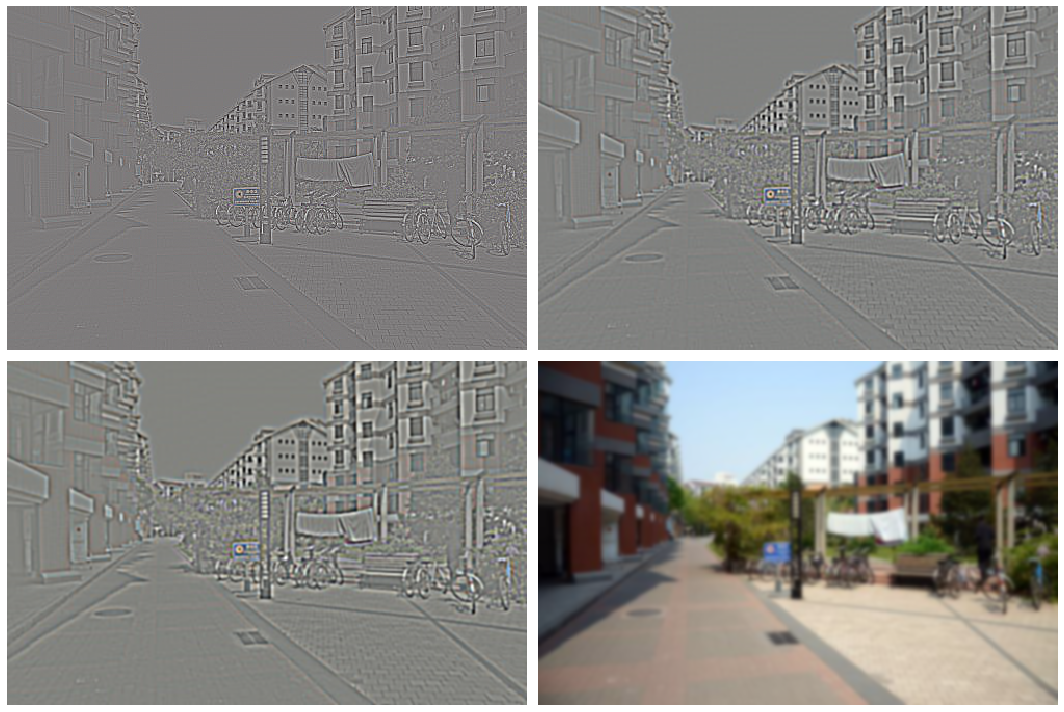

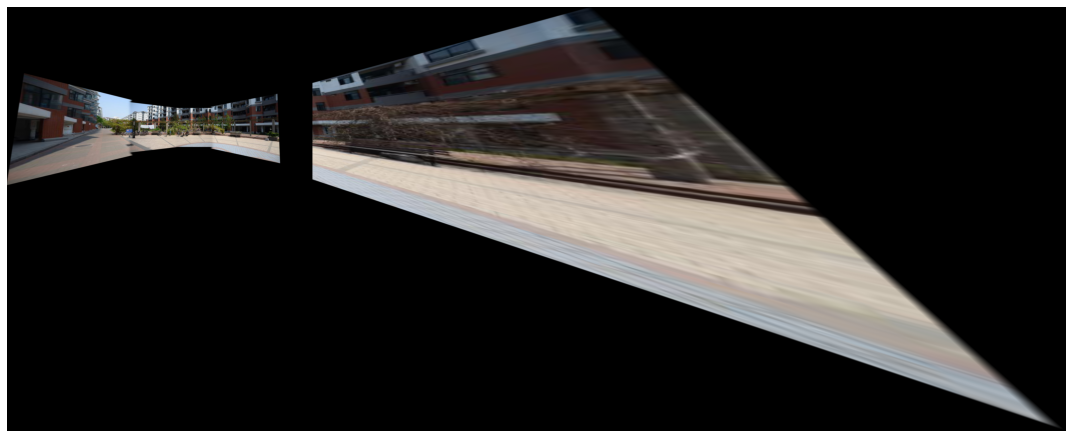

In [25]:
img = pano_image_collection[0]

laplacian_pyramid = get_laplacian_pyramid(img, 4, 1)
merged_img = merge_laplacian_pyramid(laplacian_pyramid)

# plots.plot_gauss(img, merged_img)
plots.plot_collage('', increase_contrast(laplacian_pyramid), columns=2, rows=2)

result = gaussian_merge_pano(pano_image_collection, final_center_warps, output_shape)

plots.plot_result('s.png', result)
# io.imsave('./results/improved_pano.jpeg', result)

### 7. Cylindrical

In [26]:
def cylindrical_inverse_map(coords, h, w, scale):
    """Function that transform coordinates in the output image
    to their corresponding coordinates in the input image
    according to cylindrical transform.

    Use it in skimage.transform.warp as `inverse_map` argument

    coords ((M, 2) np.ndarray) : coordinates of output image (M == col * row)
    h (int) : height (number of rows) of input image
    w (int) : width (number of cols) of input image
    scale (int or float) : scaling parameter

    Returns:
        (M, 2) np.ndarray : corresponding coordinates of input image (M == col * row) according to cylindrical transform
    """
    # your code here
    S = scale
    C = np.vstack([coords.T, np.ones(h*w)])
    K = np.array([[S, 0, w/2],
                  [0, S, h/2],
                  [0, 0, 1]])
    C_hat = inv(K) @ C
    C_x_hat, C_y_hat, _ = C_hat
    B_x_hat = np.tan(C_x_hat)
    B_y_hat = C_y_hat / np.cos(C_x_hat)
    B = (K @ np.vstack([B_x_hat, B_y_hat, np.ones(h*w)]))[:2].T
    return B


def crop_edges(img):
    mask = img[...,0] > 0
    coords = np.argwhere(mask)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    cropped = np.dstack([img[...,i][x0:x1, y0:y1] for i in range(3)])
    return cropped


def warp_cylindrical(img, scale=None, crop=True):
    """Warp image to cylindrical coordinates

    img ((H, W, 3)  np.ndarray) : image for transformation
    scale (int or None) : scaling parameter. If None, defaults to W * 0.5
    crop (bool) : crop image to fit (remove unnecessary zero-padding of image)

    Returns:
        (H, W, 3)  np.ndarray : warped image (H and W may differ from original)
    """
    # your code here
    h, w, _ = img.shape
    
    if scale is None:
        scale = w / np.pi
    
    wraped = warp(image=img, 
                  inverse_map=cylindrical_inverse_map, 
                  map_args={'h': h, 'w': w, 'scale': scale}, 
                  output_shape=img.shape)
    result = np.clip(crop_edges(wraped), 0, 1)
    return result

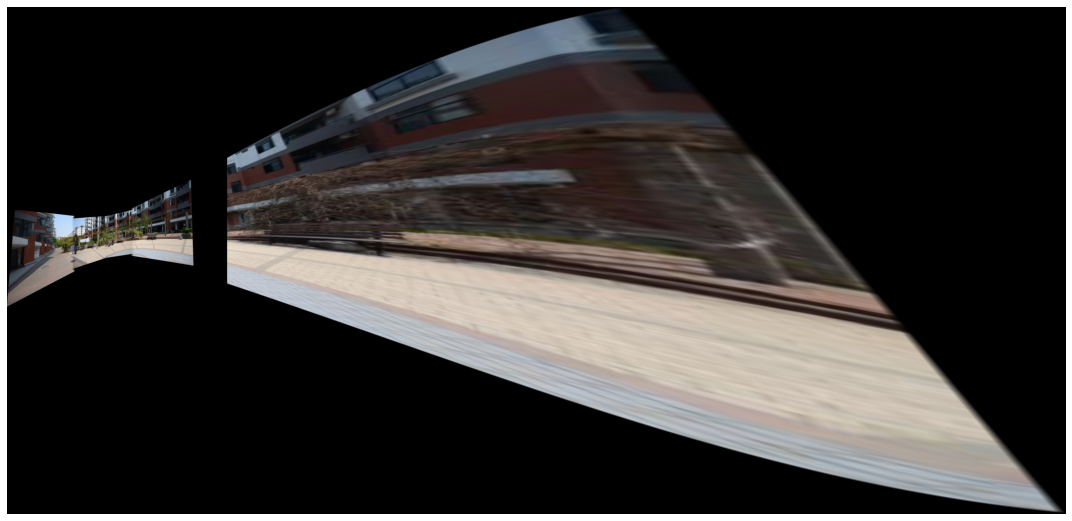

In [27]:
cylindrical = warp_cylindrical(result)

plots.plot_result('d.png', cylindrical)

<ipython-input-24-a488033e2c52>:15: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  image = gaussian(image, sigma)


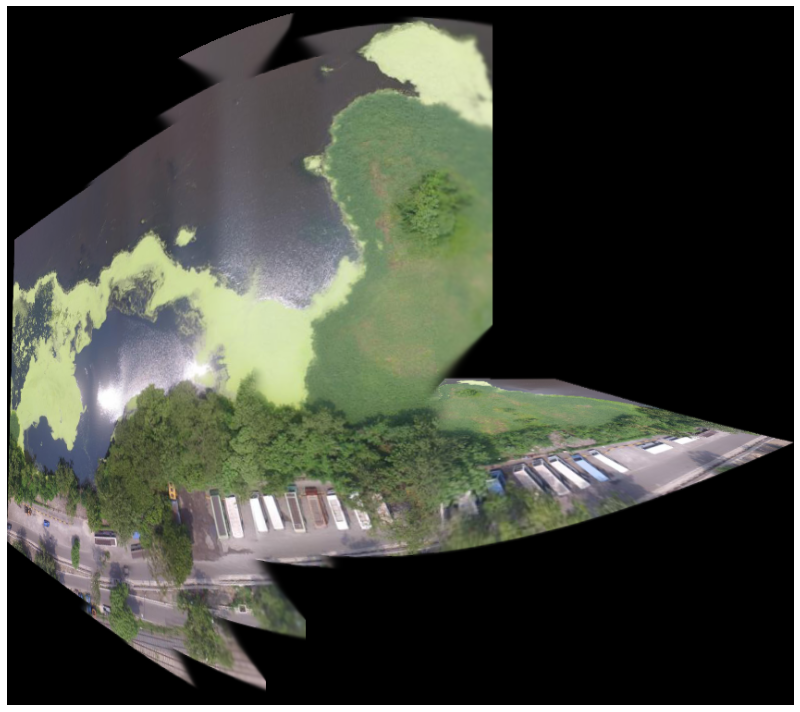

In [72]:
pano_image_collection = io.ImageCollection('imgs/04/k*.JPG',
                                           load_func=lambda f: io.imread(f).astype(np.float64) / 255)

keypoints, descriptors = zip(*(find_orb(img, 100) for img in pano_image_collection))
forward_transforms = tuple(ransac_transform(src_kp, src_desc, dest_kp, dest_desc)
                           for src_kp, src_desc, dest_kp, dest_desc
                           in zip(keypoints[:-1], descriptors[:-1], keypoints[1:], descriptors[1:]))


simple_center_warps = find_simple_center_warps(forward_transforms)
final_center_warps, output_shape = get_final_center_warps(pano_image_collection, simple_center_warps)
result = gaussian_merge_pano(pano_image_collection, final_center_warps, output_shape)
cylindrical = warp_cylindrical(result)
plots.plot_result('d.png', cylindrical)

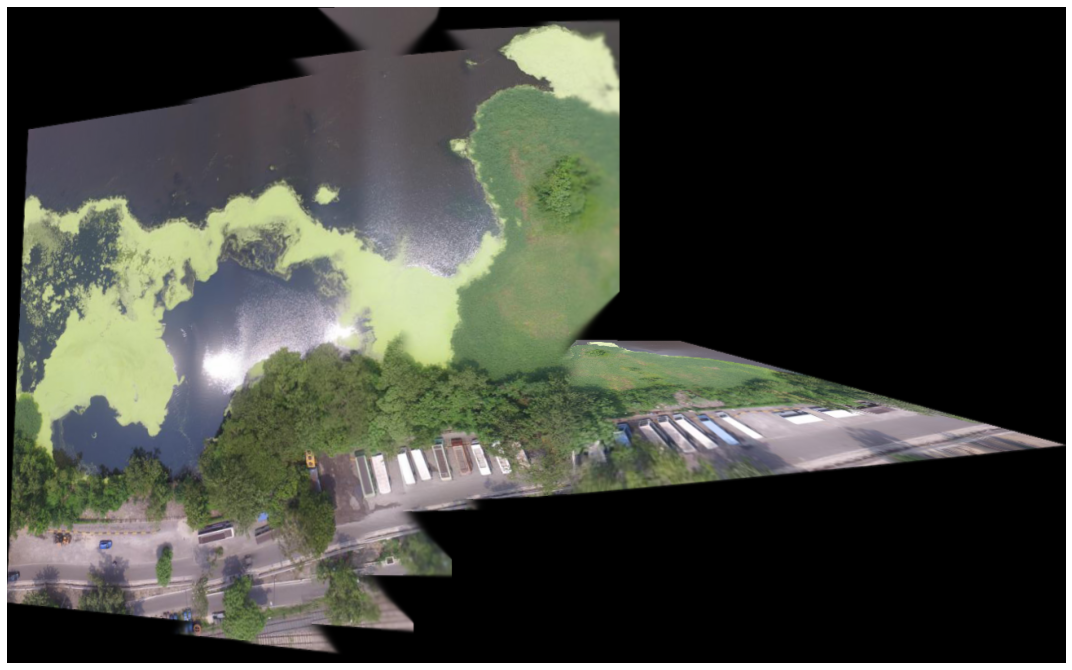

In [73]:
cylindrical = warp_cylindrical(result, scale=2500)
plots.plot_result('d.png', cylindrical)

In [74]:
result.shape

(809, 1332, 3)

In [75]:
1332/ np.pi

423.9887683968092